In [135]:
#import numpy as np
import autograd.numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import seaborn as sb
from scipy.optimize import curve_fit

# local imports
from train.dataloader import create_datasets_sim
from train.model import vgg13bn, vggSmall
from train.train import train_model

from train.GPclassification_model import GaussianProcessModel, log_lik_bernoulli, create_se_kernel, predictive

# plots setting
sb.set(font_scale=1.25)
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_train = 42

%reload_ext autoreload
%autoreload 2

# Predict steady state
Given $m$ observations from the quantum trajectory samples can we predict if the particle is in a steady state? We will try with different values of $m$. Here the labels are found from the cumulative sum of measurements.
$$
y = \sum_i^N X_i > 0 
$$
Where $X_i$ is the measurement at time step $i$ and $N$ is the number of measurements. Note the label does not depend on the number of measurements $m$.


In [136]:
# psysical model parameters
N = 100 # NOTE: must be fixed for the CNN
g = 0.25
a0 = 1/np.sqrt(2)
delta_t = 1#0.05
sigma = 1
epsilon = (2*np.pi*g)/(sigma*N*40)

find_probs = lambda a, b: np.maximum(abs(a)**2, abs(b)**2).mean(axis=0)
find_label_ss = lambda x: (x.sum(axis=-1) > 0).ravel().long()

# data
N_data = 1000
rm = 0.05
rd = 0.



# ML parameters
epochs = 10 
lr = 1e-4
batch_size = 128
folds = 10

seed_test = [seed_train + 1 + i for i in range(folds)]


In [137]:
all_testsets = [create_datasets_sim(N_data = 200,data_split=1,N=N, g=g,epsilon = epsilon,  a0=a0, delta_t = delta_t, rm = rm, rd = rd, seed = seed_test[i]) for i in range(folds)]

test_dataset  =  all_testsets[0]

Plot the data.

[94. 96. 91. 92. 94. 93. 91. 93. 93. 97. 95. 89. 94. 95. 96. 92. 96. 95.
 96. 97. 94. 91. 96. 97. 92. 96. 96. 94. 88. 88. 93. 93. 94. 95. 95. 95.
 97. 96. 97. 95. 93. 94. 93. 96. 89. 91. 95. 96. 93. 95.]
(100,)


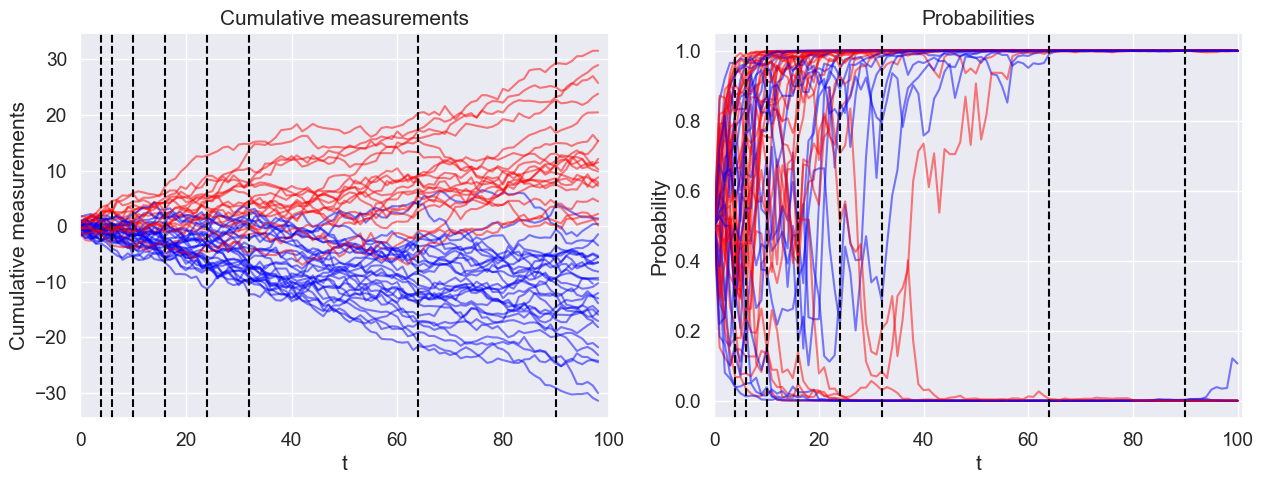

The different m values are: [90, 64, 32, 24, 16, 10, 6, 4]


In [138]:

M = [90,64, 32, 24, 16, 10, 6, 4]
Nplot = 50
# plot some examples from the dataset
Xtest, ttest, atest, btest = test_dataset.tensors

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Cumulative measurements')
end_idxes = np.ones(Nplot) * N
for i in range(Nplot):
    X = Xtest[i].numpy()
    t = ttest[i].numpy()
    # remove zerpadding in the end
    zero_idxes = np.where(t[1:] == 0)
    if len(zero_idxes[0]) > 0:
        end_idx = zero_idxes[0][0]
        end_idxes[i] = end_idx
    else:
        end_idx = N
        
    label = (X.sum(axis=-1) > 0)
  
    if label == 0:
        axes[0].plot(t[:end_idx], np.cumsum(X.squeeze(0))[:end_idx], color='blue', alpha=0.5)
    else:
        axes[0].plot(t[:end_idx], np.cumsum(X.squeeze(0))[:end_idx], color='red', alpha=0.5)
print(end_idxes)

axes[0].set_xlim([0, N*delta_t])
axes[0].set_xlabel('t')
#axes[0].set_xticks(range(0, N+1, 10))


print(t.shape)
# plot the a and b
axes[1].set_title('Probabilities')

t_ab = np.arange(0, N*delta_t + delta_t, delta_t)

for i in range(Nplot):
    label = (Xtest[i].sum(axis=-1) > 0)
    t = np.concatenate([ttest[i].numpy(), [ttest[i,-1] + delta_t]])

    #end_idx = int(end_idxex[i])
    if label == 1:
        axes[1].plot(t_ab, abs(atest[i]).numpy()**2, label= 'a', color = 'blue', alpha=0.5)
    else:
        axes[1].plot(t_ab, abs(btest[i]).numpy()**2, label= 'b', color = 'red', alpha=0.5)

# vertical lines for M
Mt = [m*delta_t for m in M]

for m in Mt:
    axes[0].axvline(m, color='black', linestyle='--')
    axes[1].axvline(m, color='black', linestyle='--')
    
# set x-axis
axes[1].set_xlim([0, N*delta_t + delta_t])
axes[1].set_xlabel('t')

# y-axis
axes[0].set_ylabel('Cumulative measurements')
axes[1].set_ylabel('Probability')


plt.show()

print(f"The different m values are: {M}")


Check the that there is enough data to train the model.

In [139]:
def test_M(X, M):
    N_data = X.shape[0]
    bool_error = False
    for i in range(N_data):
        Xi = X[i,0].numpy()
        if Xi[M] == 0:
            print(i)
            bool_error = True
    return bool_error

for i,  testset in enumerate(all_testsets):
    Xtest, ttest, atest, btest = testset.tensors
    if test_M(Xtest, M[0]):
        print(f"Error {i}")
        

    

11
28
29
44
83
Error 0
1
104
164
180
188
Error 1
63
82
Error 2
5
6
105
140
153
158
Error 3
40
61
81
86
116
167
194
Error 4
41
90
199
Error 5
4
7
104
113
125
183
Error 6
17
72
136
185
Error 7
8
15
44
57
65
141
184
196
Error 8
98
Error 9


## Noiseless data

### ML model
try and predict the steady state using a simple CNN model. 

In [140]:
# train and val dataset
train_dataset, val_dataset =  create_datasets_sim(N_data,0.8, N=N, g=g, epsilon=epsilon, a0=a0, delta_t = delta_t, rm = rm, rd = rd, seed = seed_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# check if there is enough data
Xtrain, ttrain, atrain, btrain = train_dataset.tensors
print(f"Enough data in train set: {test_M(Xtrain, M[0])} ")
Xval, tval, aval, bval = val_dataset.tensors
print(f"Enough data in test set: {test_M(Xtest, M[0])} ")

12
22
90
93
112
114
161
166
199
204
210
217
236
239
256
316
344
360
380
461
463
471
476
477
484
536
566
588
592
614
619
638
672
687
711
714
743
744
746
Enough data in train set: True 
98
Enough data in test set: True 


In [141]:
models = []
stats = []

loss_fn = torch.nn.CrossEntropyLoss() # torch.nn.BCELoss()#

for m in tqdm(M):
    # model
    model = vggSmall(num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    model, stat = train_model(model, train_loader, val_loader, m, epochs, loss_fn, optimizer, device, steady_state=True, verbose=False)

    # save
    models.append(model)
    stats.append(stat)

100%|██████████| 8/8 [00:32<00:00,  4.08s/it]


plot loss curves

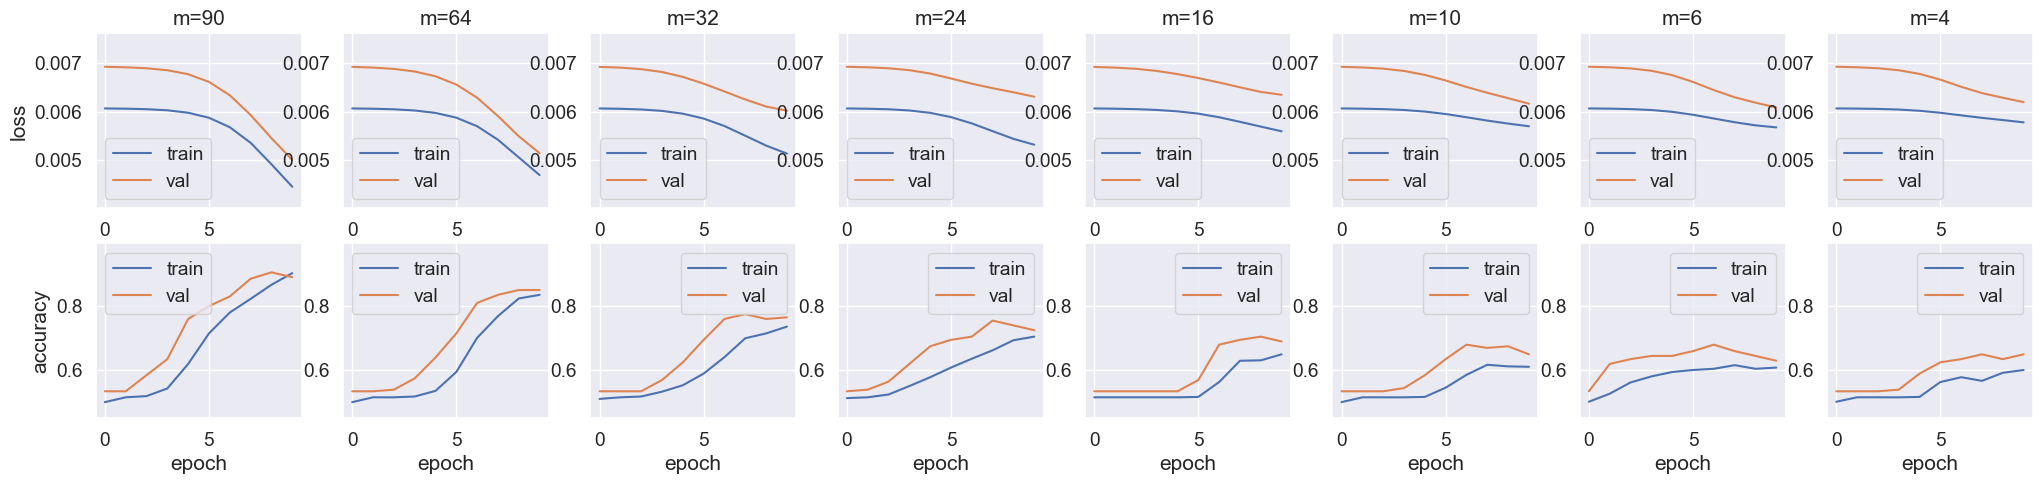

In [142]:
# overall min and max acc and losses on both train and val
min_loss = min([min(stat['train_loss']+stat['val_loss']) for stat in stats])
max_loss = max([max(stat['train_loss']+stat['val_loss']) for stat in stats])
min_acc = min([min(stat['train_acc']+stat['val_acc']) for stat in stats])
max_acc = max([max(stat['train_acc']+stat['val_acc']) for stat in stats])


fig, axes = plt.subplots(2, len(M), figsize=(25,5))

for i, stat in enumerate(stats):
    
    # set title
    axes[0,i].set_title(f"m={M[i]}")
    axes[0,i].plot(stat['train_loss'], label='train')
    axes[0,i].plot(stat['val_loss'], label='val')
    axes[0,i].legend()
    #axes[0,i].set_xlabel('epoch')
    if i == 0:
        axes[0,i].set_ylabel('loss')
    axes[0,i].set_ylim([min_loss*0.9, max_loss*1.1])
    

    axes[1,i].plot(stat['train_acc'], label='train')
    axes[1,i].plot(stat['val_acc'], label='val')
    axes[1,i].set_xlabel('epoch')
    if i==0:
        axes[1,i].set_ylabel('accuracy')
    axes[1,i].legend()
    axes[1,i].set_ylim([min_acc*0.9, max_acc*1.1])
plt.show()

### Performance on the test set
how is the performance on the test set?

In [143]:
# Get the train exact probabilities
_, _, atrain, btrain = train_dataset.tensors


train_qprobs = find_probs(atrain, btrain)

# test with ensemble
test_acc = np.zeros((len(M), folds))
test_qprobs = np.zeros((N+1, folds))


for i, model in enumerate(models):
    for j in range(folds):
        acc = 0
        test_dataset  =  all_testsets[j]
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
        _, _, atest, btest = test_dataset.tensors
        for X, t, a, b in test_loader:
            Xm = X[:,:,:M[i]]
            y = find_label_ss(X)
            yhat = model(Xm)
            acc += (yhat.argmax(1) == y).float().mean().item()

        test_acc[i,j] = acc/len(test_loader)
        test_qprobs[:,j] = find_probs(atest, btest)

mean_test_acc = test_acc.mean(axis=1)


/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_12968/3686849784.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_qprobs[:,j] = find_probs(atest, btest)


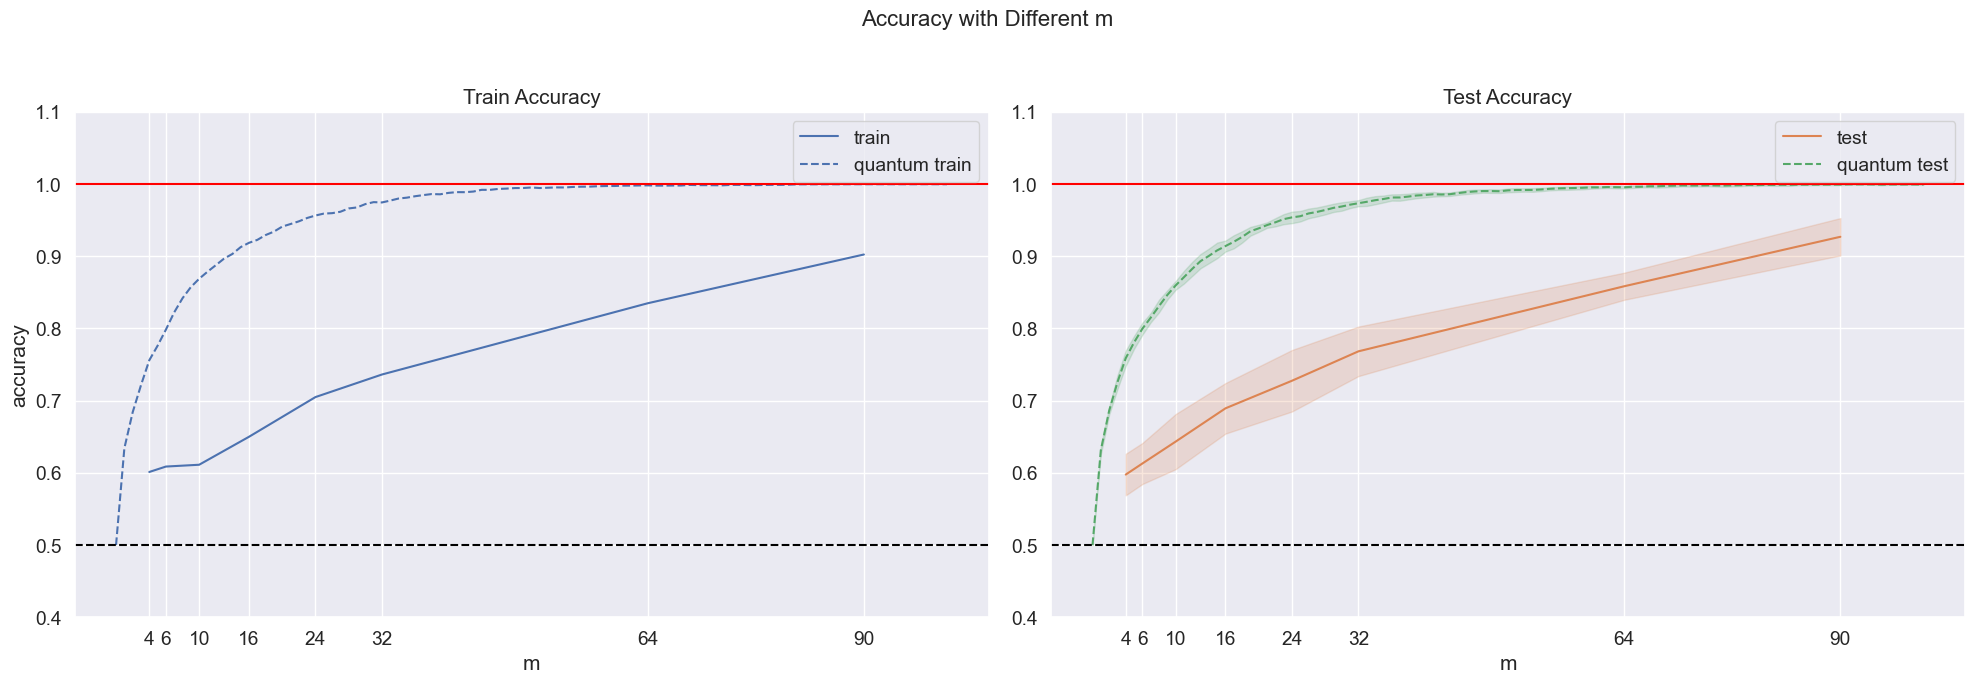

In [144]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 rows, 1 column
fig.suptitle('Accuracy with Different m', fontsize=16)

# Train Plot
axes[0].plot(M, [stat['train_acc'][-1] for stat in stats], label='train', color='C0')
axes[0].plot(range(N + 1), train_qprobs, label='quantum train', color='C0', linestyle='--')
axes[0].set_title('Train Accuracy')
axes[0].set_xlabel('m')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim(0.4, 1.1)
axes[0].set_xticks(M)
axes[0].axhline(0.5, color='black', linestyle='--')
axes[0].axhline(1, color='red')
axes[0].legend()

# Test Plot
axes[1].plot(M, mean_test_acc, label='test', color='C1')
axes[1].fill_between(M, mean_test_acc - test_acc.std(axis=1), mean_test_acc + test_acc.std(axis=1), alpha=0.2, color='C1')
axes[1].plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum test', color='C2', linestyle='--')
axes[1].fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('m')
#axes[1].set_ylabel('accuracy')
axes[1].set_ylim(0.4, 1.1)
axes[1].set_xticks(M)
axes[1].axhline(0.5, color='black', linestyle='--')
axes[1].axhline(1, color='red')
axes[1].legend()

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.savefig('figures/CNN_results_subplot.png')
plt.show()

save models and Close for memory

### Bayesian machine learning model
Using gaussian process to classify the steady state. We will use the following model:
$$\begin{align*}
t|y(\mathbf{x}) &\sim \text{Ber}[\sigma(y(\mathbf{x}))]\\
y(\mathbf{x}) &\sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}')),
\end{align*}$$
The posterior distribution will be approximated using laplace approximation:
$$\begin{align*}
p(\mathbf{y}|\mathbf{t}) = \frac{p(\mathbf{t}|\mathbf{y})p(\mathbf{y})}{p(\mathbf{t})} \approx q(\mathbf{y}) = \mathcal{N}(\mathbf{y}| \mathbf{m}, \mathbf{S}) \tag{1},
\end{align*}$$
From this the predictive posterior distribution is:
$$\begin{align*}
p(y^*|\mathbf{t}, \mathbf{x}^*) &= \int p(y^*|\mathbf{y}, \mathbf{x}^*) p(\mathbf{y}|\mathbf{t}) \text{d} \mathbf{y}\approx  \int p(y^*|\mathbf{y}) q(\mathbf{y}) \text{d} \mathbf{y} = \mathcal{N}(y^*|\mu_{y^*}, \sigma^2_{y^*}),
\end{align*}$$
To evaluate the prdictive distribution we can use monte carlo or probit approximation (maybe variational inference?).



In [145]:
find_label = lambda am, bm: np.array((np.abs(am)**2 > np.abs(bm)**2).unsqueeze(1))
# unpack data
Xtrain, ttrain, atrain, btrain = train_dataset.tensors
ytrain = np.array(find_label_ss(Xtrain).unsqueeze(1))
Xtrain = np.array(Xtrain.squeeze(1))
ttrain = np.array(ttrain.unsqueeze(1))

print(f'Xtrain shape: {Xtrain.shape} \tytrain shape: {ytrain.shape}') 


Xtest, ttest, atest,btest = all_testsets[0].tensors
ytest = np.array(find_label_ss(Xtest).unsqueeze(1))
Xtest = np.array(Xtest.squeeze(1))
print(f'Xtest shape: {Xtest.shape} \tytest shape: {ytest.shape}') 

Xtrain shape: (800, 100) 	ytrain shape: (800, 1)
Xtest shape: (200, 100) 	ytest shape: (200, 1)


Kernel matrix shape: (800, 800)	Max value 1.000001
All positive eigenvalues: True	lowerst 0.36258682608608533

idx: (800,)
number of positive examples: 387 	 number of negative examples: 413


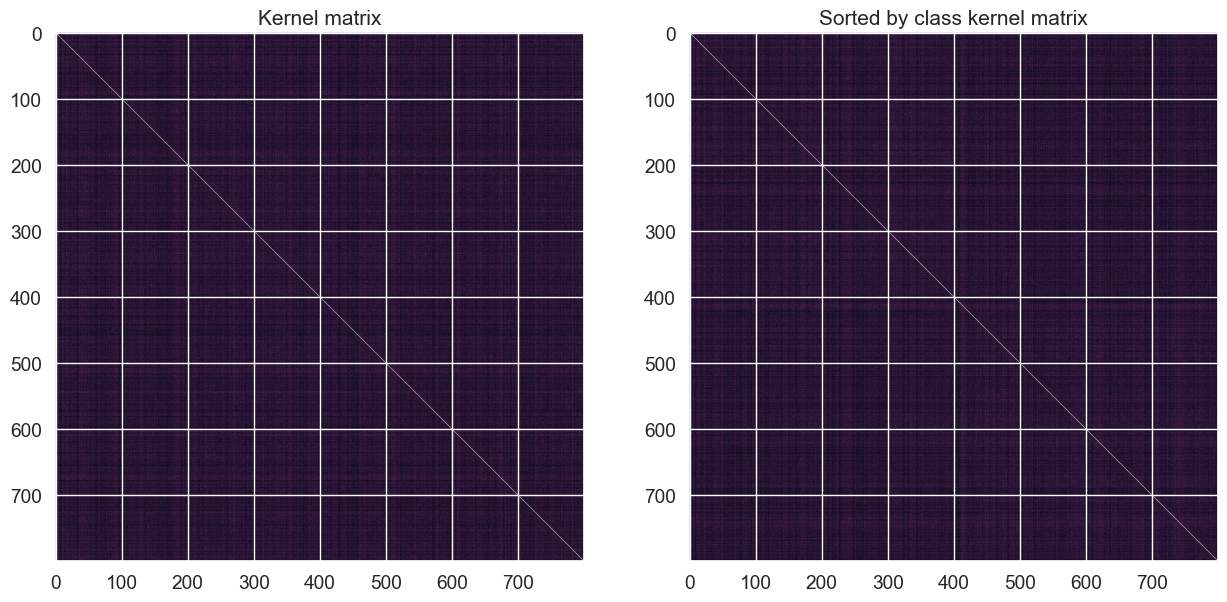

In [146]:

# Gaussian process parameters
kappa = 1.
scale = 5.
theta = [kappa, scale]

K = create_se_kernel(Xtrain, Xtrain, theta)

print(f'Kernel matrix shape: {K.shape}\tMax value {K.max()}')
# check the kernel is positive semidifinite
eigenvalues = linalg.eigvalsh(K)
print(f"All positive eigenvalues: {all(eigenvalues > 0)}\tlowerst {eigenvalues.min()}\n")
# Sort kernel matrix so the classes are grouped
idx = np.argsort(ytrain.squeeze())

print(f"idx: {idx.shape}")


K_sort = K[idx][:,idx]
print(f'number of positive examples: {np.sum(ytrain)} \t number of negative examples: {len(ytrain) - np.sum(ytrain)}')

# plot the kernel
figs, axes = plt.subplots(1,2, figsize=(15,10))

axes[0].imshow(K)
axes[0].set_title('Kernel matrix')

axes[1].imshow(K_sort)
axes[1].set_title('Sorted by class kernel matrix')

plt.show()


Define gaussian process model

In [147]:
gp = GaussianProcessModel(Xtrain, ytrain, theta, log_lik_bernoulli)

# predictions
ptrain = predictive(Xtrain, gp)
ptest = predictive(Xtest, gp)  

Plot predictions probabilities

(387,) (413,)


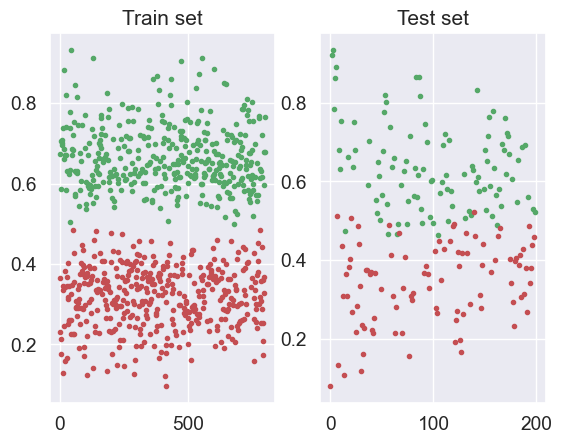

In [148]:
idx_positive, _ = np.where(ytrain)
idx_negative, _ = np.where(1 - ytrain)

print(idx_positive.shape, idx_negative.shape)
plt.subplot(1,2,1)
plt.plot(idx_positive, ptrain[idx_positive], 'g.')
plt.plot(idx_negative, ptrain[idx_negative],'r.')
plt.title('Train set')


idx_positive, _ = np.where(ytest)
idx_negative, _ = np.where(1 - ytest)

plt.subplot(1,2,2)

plt.plot(idx_positive, ptest[idx_positive], 'g.')
plt.plot(idx_negative, ptest[idx_negative],'r.')
plt.title('Test set')

plt.show()

Make predictions with 0,5 threshold and find the accuracy

In [149]:
# make predictions
ytrain_hat = 1.0*(ptrain > 0.5)
ytest_hat = 1.0*(ptest > 0.5)

def compute_err(t, tpred):
    return np.mean(tpred.ravel() == t.ravel()), np.std(tpred.ravel() == t.ravel)/np.sqrt(len(t))

train_err = compute_err(ytrain.ravel(), ytrain_hat.ravel())
test_err = compute_err(ytest.ravel(), ytest_hat)

print(f'Train error: {train_err[0]:.3f} +- {train_err[1]:.3f}')
print(f'Test error: {test_err[0]:.3f} +- {test_err[1]:.3f}')

Train error: 0.999 +- 0.000
Test error: 0.935 +- 0.000


### With fewer observations
The same experiment but with fewer observations.

In [150]:
K_m = []
error_test = np.zeros((len(M), folds))
error_train = np.zeros((len(M)))

for i, m in enumerate(M):
    print(f"m={m}")
    Xtrain_m = Xtrain[:,:m]
    Xtest_m = Xtest[:,:m]
    #ytrain = np.array(find_label_ss(Xtrain).unsqueeze(1))

    # Check kernel 
    K = create_se_kernel(Xtrain_m, Xtrain_m, theta)
    K_m.append(K)

    # train model and make predictions
    gp = GaussianProcessModel(Xtrain_m, ytrain, theta, log_lik_bernoulli)

    # train error
    ptrain = predictive(Xtrain_m, gp)
    ytrain_hat = 1.0*(ptrain > 0.5)
    error_train[i] = compute_err(ytrain, ytrain_hat)[0] # Note could use std as well


    # test ensamble
    for j, data in enumerate(all_testsets):
        Xtest, _, atest,btest = data.tensors
        Xtest_m = Xtest.squeeze(1)[:,:m]
        ytest = np.array(find_label_ss(Xtest).unsqueeze(1))
        
        ptest = predictive(Xtest_m, gp)
        ytest_hat = 1.0*(ptest > 0.5)
        error_test[i, j] = compute_err(ytest, ytest_hat)[0]


m=90
m=64
m=32
m=24
m=16
m=10
m=6
m=4


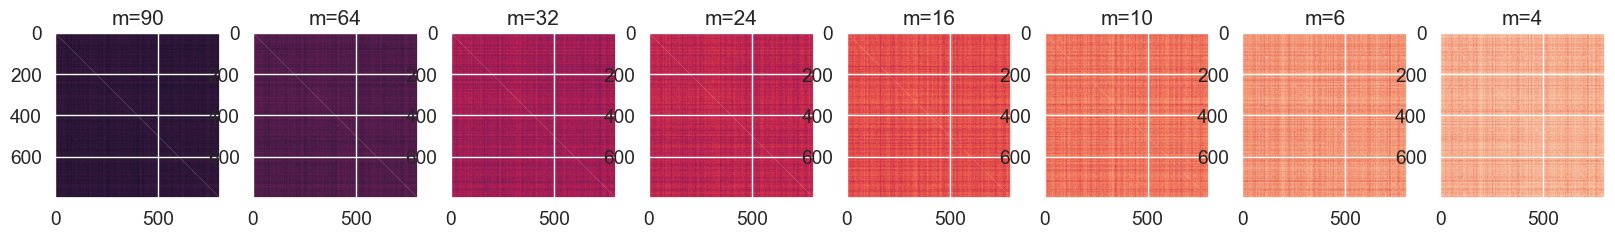

In [151]:
# plot the kernels
figs, axes = plt.subplots(1,len(M), figsize=(20,5))
for i, K in enumerate(K_m):
    idx = np.argsort(ytrain.squeeze())
    K_sort = K[idx][:,idx]
    axes[i].imshow(K_sort)
    axes[i].set_title(f'm={M[i]}')
plt.show()

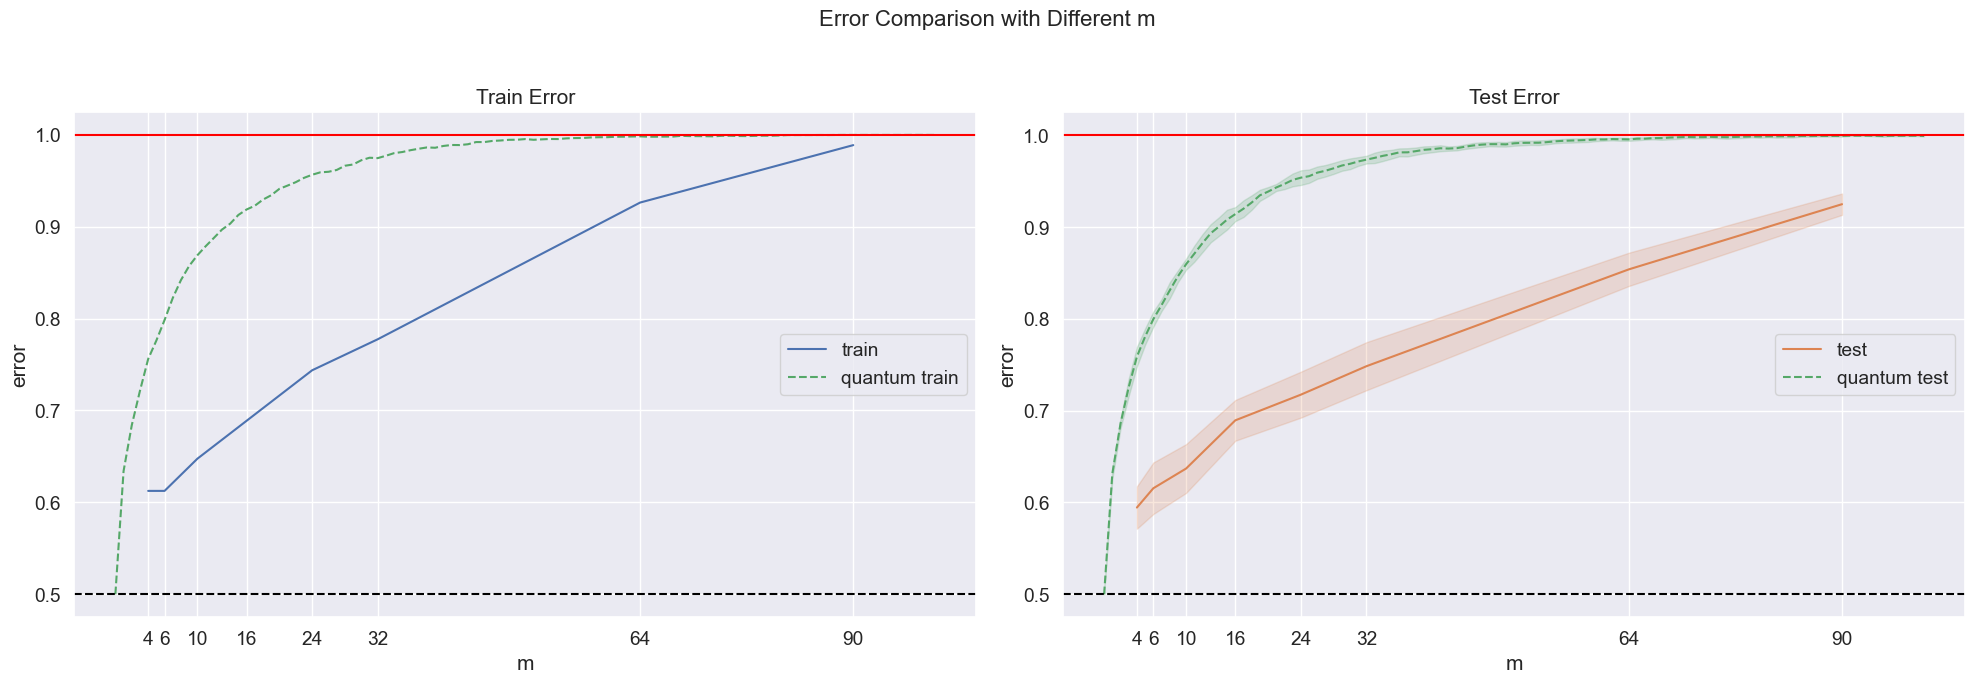

In [152]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))  # 2 rows, 1 column
fig.suptitle('Error Comparison with Different m', fontsize=16)

# Train Error Plot
axes[0].plot(M, error_train, label='train', color='C0')
axes[0].plot(range(N + 1), train_qprobs, label='quantum train', color='C2', linestyle='--')
axes[0].set_title('Train Error')
axes[0].set_xlabel('m')
axes[0].set_ylabel('error')
axes[0].set_xticks(M)
axes[0].axhline(0.5, color='black', linestyle='--')
axes[0].axhline(1, color='red')
axes[0].legend()

# Test Error Plot
axes[1].plot(M, error_test.mean(axis=1), label='test', color='C1')
axes[1].fill_between(M, 
                     error_test.mean(axis=1) - error_test.std(axis=1), 
                     error_test.mean(axis=1) + error_test.std(axis=1), 
                     alpha=0.2, color='C1')
axes[1].plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum test', color='C2', linestyle='--')
axes[1].fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
axes[1].set_title('Test Error')
axes[1].set_xlabel('m')
axes[1].set_ylabel('error')
axes[1].set_xticks(M)
axes[1].axhline(0.5, color='black', linestyle='--')
axes[1].axhline(1, color='red')
axes[1].legend()

# Adjust layout and show/save
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.savefig('figures/Error_Comparison_subplot.png')
plt.show()

Show results with other parameters.

$\kappa$ hvor store hop kan jeg lave
$l$ range for meausurement records

### Compare the models


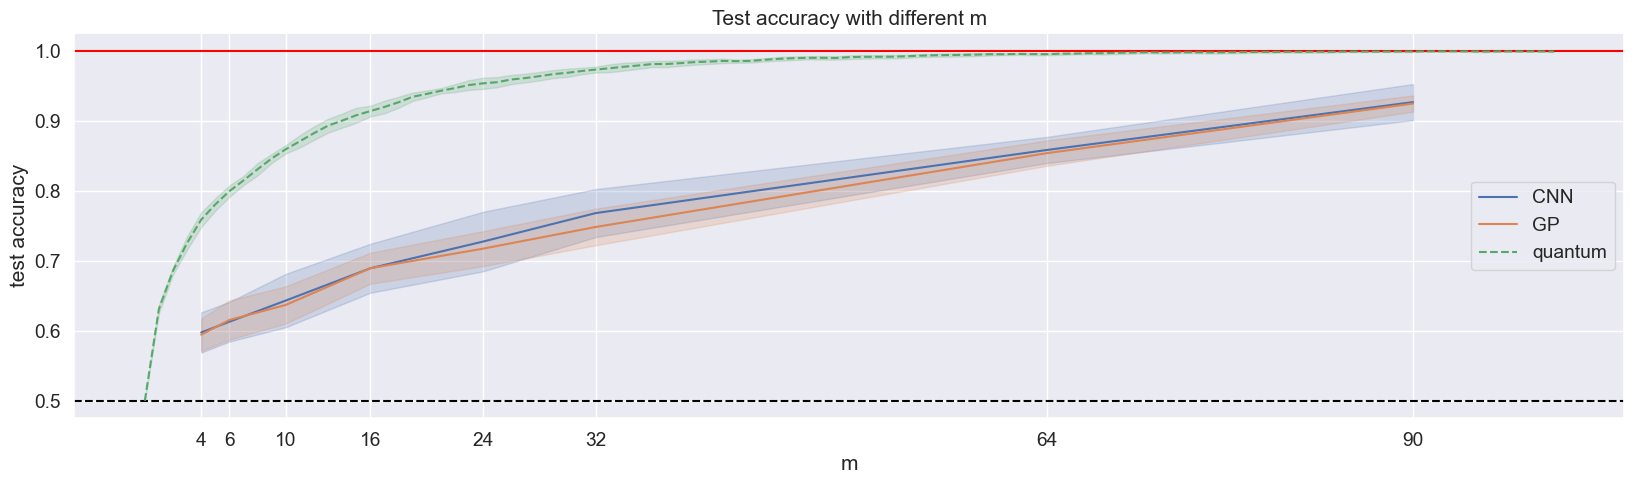

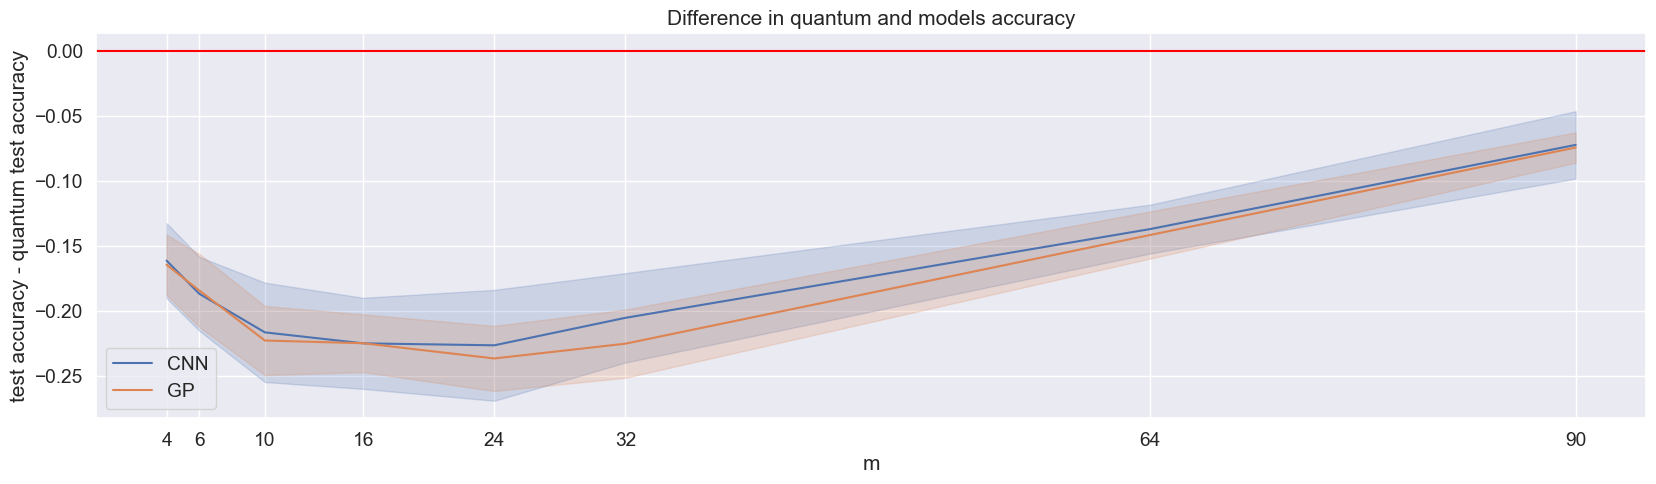

In [153]:
plt.figure(figsize=(20,5))
plt.title('Test accuracy with different m')
# Lines
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(1, color='red')
# CNN
plt.plot(M, mean_test_acc, label='CNN', color='C0')
plt.fill_between(M, mean_test_acc - test_acc.std(axis=1), mean_test_acc + test_acc.std(axis=1), alpha=0.2, color='C0')
# GP
plt.plot(M, error_test.mean(axis=1), label='GP', color='C1')
plt.fill_between(M, 
                     error_test.mean(axis=1) - error_test.std(axis=1), 
                     error_test.mean(axis=1) + error_test.std(axis=1), 
                     alpha=0.2, color='C1')
plt.plot(range(N + 1), test_qprobs.mean(axis=1), label='quantum', color='C2', linestyle='--')
plt.fill_between(range(N + 1), 
                     test_qprobs.mean(axis=1) - test_qprobs.std(axis=1), 
                     test_qprobs.mean(axis=1) + test_qprobs.std(axis=1), 
                     alpha=0.2, color='C2')
plt.xlabel('m')
plt.ylabel('test accuracy')
#plt.ylim(0.8,1.1)
plt.xticks(M)

plt.legend()
plt.show()

# Plot with deviation from test_qprobs
plt.figure(figsize=(20,5))
plt.title('Difference in quantum and models accuracy')
plt.axhline(0, color='red')
plt.plot(M, mean_test_acc - test_qprobs[M,:].mean(axis=1), label='CNN', color='C0')
plt.fill_between(M,
                    mean_test_acc - test_qprobs[M,:].mean(axis=1) - test_acc.std(axis=1),
                    mean_test_acc - test_qprobs[M,:].mean(axis=1) + test_acc.std(axis=1),
                    alpha=0.2, color='C0')
plt.plot(M, error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1), label='GP', color='C1')
plt.fill_between(M,
                    error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1) - error_test.std(axis=1),
                    error_test.mean(axis=1) - test_qprobs[M,:].mean(axis=1) + error_test.std(axis=1),
                    alpha=0.2, color='C1')
plt.xlabel('m')
plt.ylabel('test accuracy - quantum test accuracy')
plt.xticks(M)
#plt.axhline(0, color='C2', linestyle='--', legend='quantum')
plt.legend()
#plt.ylim(-0.1, 0.1)
plt.show()

